In [129]:

import os
import sys
module_path = os.path.abspath(os.pardir)
if module_path not in sys.path:
    sys.path.append(module_path)
from src import data_download
import pandas as pd
import numpy as np
import scipy
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.regression.linear_model
import statsmodels.stats as stats
import statsmodels.stats.api as sms
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
import sklearn.metrics as metrics
from sklearn.feature_selection import RFECV
from statsmodels.stats.diagnostic import linear_rainbow
from statsmodels.stats.outliers_influence import variance_inflation_factor


%matplotlib inline
pd.set_option('display.max_columns', None)

## Load data
1. All 3 tables are merged
2. Tables are filtere to only include sales in 2019 of homes between 120,000 and 3,000,000 dollars
3. Merged table is divided into 2 tables: ordtable = ordinal features, cattable = categorical features.

We chose to separate the tables to make modeling easier, and make clear what needs to be one-hotted before adding to the model.

data_dict = data_download.get_dataframes()

In [130]:
data_dict['rp_sale'] = data_dict['rp_sale'][(data_dict['rp_sale']['SalePrice'] > 200000) & (data_dict['rp_sale']['SalePrice'] < 1500000)]

ordtable, cattable = data_download.get_tables(data_dict)

In [131]:
for x in cattable.columns:
    cattable[x] = cattable[x].astype('category')

## Let RFECV choose my features for me

## Feed the selected predictors into the regression model

In [201]:
predictors = ordtable.drop(columns = ['SalePrice']).copy()
y = ordtable.SalePrice.copy()
y = y.reset_index(drop=True)
#todrop = ['FinBasementGrade','SqFtFinBasement','NbrLivingUnits', 'PugetSound',
#          'SqFt1stFloor','Stories','SqFtTotBasement','BrickStone','FpSingleStory']
#predictors['BldgGrade'] = predictors['BldgGrade'].astype('category')
predictors['PropertyClass'] = cattable['PropertyClass']
predictors['InadequateParking'] = cattable['InadequateParking']
predictors['SaleReason'] = cattable['SaleReason']
#predictors['YrBuilt'] = predictors['YrBuilt'].astype('category')
predictors['WfntLocation'] = cattable['WfntLocation']
#predictors['AdjacentGreenbelt'] = cattable['AdjacentGreenbelt']
#predictors['AdjacentGolfFairway'] = cattable['AdjacentGolfFairway']
#predictors[''] = cattable['']
#predictors['Condition'] = predictors['Condition'].astype('category')

predictors = pd.get_dummies(predictors, drop_first = True)

todrop =    ['SqFtLot','SqFt1stFloor','PropertyClass_7',
             'PropertyClass_8','SqFtTotBasement','SqFtFinBasement']
predictors = predictors.drop(columns = todrop)
standardords = predictors



pt = preprocessing.StandardScaler()
standardords = pd.DataFrame(pt.fit_transform(predictors))
standardords.columns = predictors.columns


lr = LinearRegression(normalize = False)
select = RFECV(lr)
select = select.fit(X = standardords, y = y)

selected_scales = pt.scale_[select.support_]
selected_scales = np.insert(selected_scales,0,1) #add one for the intercept

X = standardords[standardords.columns[list(select.support_)]].reset_index(drop=True)

results = sm.OLS(y, sm.add_constant(X)).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.466
Model:                            OLS   Adj. R-squared:                  0.465
Method:                 Least Squares   F-statistic:                     624.6
Date:                Fri, 02 Oct 2020   Prob (F-statistic):               0.00
Time:                        11:33:30   Log-Likelihood:            -3.5169e+05
No. Observations:               25780   AIC:                         7.035e+05
Df Residuals:                   25743   BIC:                         7.038e+05
Df Model:                          36                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                 6.84e+05   1267.824    539.490      0.000    6.81e+05    6.86e+05
BrickStone           5987.0448   1331.518      4.496      0.000    3377.195    8596.895
Stories              3.497e+04   2126.670     16.442      0.000    3.08e+04    3.91e+04
BldgGrade            1.301e+05   2025.540     64.229      0.000    1.26e+05    1.34e+05
SqFtUpperFloor       5140.4307   1505.159      3.415      0.001    2190.234    8090.627
SqFtTotLiving        8.745e+04   2600.601     33.628      0.000    8.24e+04    9.26e+04
SqFtGarageBasement  -7192.7782   1578.921     -4.556      0.000   -1.03e+04   -4098.004
FinBasementGrade     1.553e+04   1753.205      8.860      0.000    1.21e+04     1.9e+04
SqFtGarageAttached  -3.049e+04   1963.522    -15.528      0.000   -3.43e+04   -2.66e+04
SqFtOpenPorch        1.034e+04   1441.258      7.174      0.000    7514.020    1.32e+04
SqFtDeck             6771.3343   1383.527      4.894      0.000    4059.544    9483.125
Bedrooms            -2.625e+04   1776.256    -14.779      0.000   -2.97e+04   -2.28e+04
BathHalfCount       -4707.3654   1596.882     -2.948      0.003   -7837.343   -1577.388
Bath3qtrCount        2.305e+04   1874.944     12.294      0.000    1.94e+04    2.67e+04
BathFullCount        2.064e+04   2198.582      9.387      0.000    1.63e+04    2.49e+04
FpFreestanding      -7114.2240   1303.780     -5.457      0.000   -9669.706   -4558.742
FpAdditional        -7991.2928   1509.717     -5.293      0.000    -1.1e+04   -5032.163
YrBuilt             -8.211e+04   1896.120    -43.306      0.000   -8.58e+04   -7.84e+04
AddnlCost           -1.258e+04   1309.865     -9.602      0.000   -1.51e+04      -1e+04
MtRainier           -7785.4051   1334.004     -5.836      0.000   -1.04e+04   -5170.682
Olympics             7559.1159   1463.327      5.166      0.000    4690.913    1.04e+04
Territorial          4255.5968   1728.671      2.462      0.014     867.304    7643.889
SeattleSkyline       9433.9126   1315.421      7.172      0.000    6855.613     1.2e+04
LakeWashington       7600.4531   1478.091      5.142      0.000    4703.312    1.05e+04
LakeSammamish        9683.8660   1297.064      7.466      0.000    7141.548    1.22e+04
LotDepthFactor      -3687.8757   1514.172     -2.436      0.015   -6655.737    -720.014
InadequateParking_2  6289.6878   1280.498      4.912      0.000    3779.840    8799.536
SaleReason_4        -1.042e+04   1270.751     -8.201      0.000   -1.29e+04   -7930.667
SaleReason_8        -7176.7309   1271.994     -5.642      0.000   -9669.910   -4683.552
SaleReason_12       -9101.5587   1268.653     -7.174      0.000   -1.16e+04   -6614.927
SaleReason_14       -5980.3490   1273.211     -4.697      0.000   -8475.915   -3484.783
SaleReason_16       -4027.6941   1268.164     -3.176      0.001   -6513.367   -1542.021
Sal

In [196]:
coefficients = results.params / selected_scales
coefficients

const                  683977.680140
BrickStone                384.227228
Stories                 64755.997306
BldgGrade              128307.628114
SqFtUpperFloor             55.496069
SqFtTotLiving             104.231566
SqFtGarageBasement        -40.833258
FinBasementGrade         4456.899256
SqFtGarageAttached       -110.377343
SqFtOpenPorch              89.838918
SqFtDeck                   32.768040
Bedrooms               -28060.537016
BathHalfCount           -9096.640814
Bath3qtrCount           36858.934206
BathFullCount           30548.776356
FpFreestanding         -29187.379773
FpAdditional           -21494.990461
YrBuilt                 -2598.853012
AddnlCost                  -6.001277
SqFtLot                     0.056127
MtRainier              -35843.008963
Olympics                24350.661338
Territorial              6084.729997
SeattleSkyline          54939.324499
LakeWashington          30432.702567
LakeSammamish           86774.981548
LotDepthFactor          -4058.504121
I

### Assumption Testing

### Homoskedasticity:


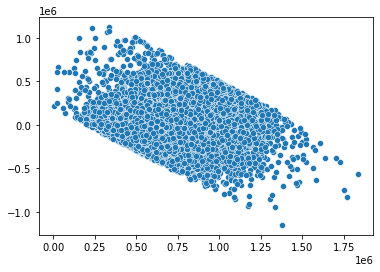

In [197]:
y_hat = results.predict()
sns.scatterplot(x = y_hat, y = results.resid)

### Linearity

We pass the linear rainbow test for linearity with flying colors by soundly rejecting the null hypothesis of non-linearity. 

#### Linear Rainbow Test:

In [198]:
rainbow_statistic, rainbow_p_value = linear_rainbow(results)
print( f'rainbow Statistic: {rainbow_statistic}')
print(f'rainbow pvalue: {rainbow_p_value}')


rainbow Statistic: 0.9547551071936782
rainbow pvalue: 0.995683656258746


### Normality
 

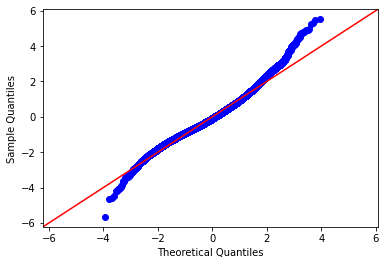

In [199]:
fig = sm.graphics.qqplot(results.resid, dist = scipy.stats.norm, line = '45', fit=True)

### Independence (collinearity)
Our model does not violate the indepedence assumption.
Our above condition score is low, suggesting low multi-collinearity between features. The below variance inflaction test shows that no feature scores above a 5.  This confirms that our features are independent.

In [200]:
rows = X.values

vif_df = pd.DataFrame()
vif_df["VIF"] = [variance_inflation_factor(rows, i) for i in range(len(X.columns))]
vif_df["feature"] = X.columns

vif_df

,VIF,feature
0,1.103029,BrickStone
1,2.818205,Stories
2,2.554398,BldgGrade
3,1.409443,SqFtUpperFloor
4,4.246479,SqFtTotLiving
5,1.551141,SqFtGarageBasement
6,1.915678,FinBasementGrade
7,2.399468,SqFtGarageAttached
8,1.301506,SqFtOpenPorch
9,1.199104,SqFtDeck
